# XHEC: Session 6-2  

Explore topic extraction and sentiment analysis existing libraries 

## Import libraries 

In [4]:
!git clone https://github.com/rwalk/gsdmm
!pip install transformers==2.4.1
!pip install flair

Cloning into 'gsdmm'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [183]:
import os
import numpy as np
import pandas as pd
import pickle
import gensim
import gensim.corpora as corpor
import pyLDAvis.gensim
import pyLDAvis
from gsdmm.gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
import operator
from tqdm import tqdm_notebook as tqdm
import flair
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
nltk.download('vader_lexicon')
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-03-11 20:13:52,536 loading file /home/leonardo/.flair/models/imdb-v0.4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data 

In [209]:
from data import jl_to_df

In [210]:
# bokan37 = pd.read_csv("data/Bokan_37.csv")
# bokan39 = pd.read_csv("data/Bokan_38_39.csv")
boisdale = jl_to_df.read_jl_file("data/Boisdale.jl")
cinnamon = jl_to_df.read_jl_file("data/Cinnamon.jl")
ivy = jl_to_df.read_jl_file("data/Ivy.jl")
peninsula = jl_to_df.read_jl_file("data/Peninsula.jl")

In [211]:
document = pd.concat([boisdale, cinnamon, ivy, peninsula], axis = 0)

check

In [212]:
len(document) == sum(map(lambda x: len(x),[boisdale, cinnamon, ivy, peninsula]))

True

In [213]:
document.head()

,id_resto,id_comment,resto,resto_url,rating,title,diner_date,rating_date,answer_text,reviewer_pseudo,reviewer_origin,reviewer_info_sup,other_ratings_category,other_ratings_value,url,content
0,g186338-d2180904,g186338-d2180904-r747618087,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Fabulous ambience and delightful service from ...,February 2020,25 February 2020,None,Hopesprings1,"[Sunningdale, United Kingdom]","[[pencil-paper, 2]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,"[Fabulous food, service and old school live Ja..."
1,g186338-d2180904,g186338-d2180904-r744514687,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Upscale McDonalds,February 2020,12 February 2020,None,futtock21,"[London, United Kingdom]","[[pencil-paper, 2802], [thumbs-up-fill, 1252]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[Boisdale Canary Wharf is part of a coterie of...
2,g186338-d2180904,g186338-d2180904-r743436725,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Good night out!,January 2020,6 February 2020,None,Jan S,"[Hornchurch, United Kingdom]","[[pencil-paper, 94], [thumbs-up-fill, 54]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[My first visit to Boisdale. I visited on a Fr...
3,g186338-d2180904,g186338-d2180904-r743081178,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,"Very good, will return",February 2020,4 February 2020,None,tripbiscuit,"[London, UK]","[[pencil-paper, 113], [thumbs-up-fill, 83]]","[Value, Service, Food]","[50, 50, 50]",https://www.tripadvisor.co.uk/ShowUserReviews-...,[I took advantage of a groupon offer as I was ...
4,g186338-d2180904,g186338-d2180904-r744537071,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,3,Boisdale,February 2020,12 February 2020,None,grahamm586,[],"[[pencil-paper, 3]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[Not very busy when we visited. Service pretty...


In [214]:
document.rating = document.rating.astype(int)

In [215]:
document = document.loc[document.rating == 5, :]

In [216]:
document.head()

,id_resto,id_comment,resto,resto_url,rating,title,diner_date,rating_date,answer_text,reviewer_pseudo,reviewer_origin,reviewer_info_sup,other_ratings_category,other_ratings_value,url,content
3,g186338-d2180904,g186338-d2180904-r743081178,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,"Very good, will return",February 2020,4 February 2020,None,tripbiscuit,"[London, UK]","[[pencil-paper, 113], [thumbs-up-fill, 83]]","[Value, Service, Food]","[50, 50, 50]",https://www.tripadvisor.co.uk/ShowUserReviews-...,[I took advantage of a groupon offer as I was ...
9,g186338-d2180904,g186338-d2180904-r746568041,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,Boisdale Another Visit,February 2020,21 February 2020,None,135alisterm,"[Glasgow, United Kingdom]","[[pencil-paper, 22], [thumbs-up-fill, 11]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[We have visited Boisdales again this week for...
10,g186338-d2180904,g186338-d2180904-r742667040,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,Sunday lunch,February 2020,2 February 2020,None,nicky b,[hertfordshire],"[[pencil-paper, 12], [thumbs-up-fill, 33]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[100% bang on the money zero complaints cant w...
11,g186338-d2180904,g186338-d2180904-r735607245,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,What a start to Christmas,December 2019,30 December 2019,None,KeithE694,[Westerham],"[[pencil-paper, 5], [thumbs-up-fill, 2]]","[Value, Service, Food]","[40, 50, 50]",https://www.tripadvisor.co.uk/ShowUserReviews-...,[had a table at the Frank and Dean show event ...
13,g186338-d2180904,g186338-d2180904-r734816254,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,Had the best night at the Frank & Dean xmas show,December 2019,26 December 2019,None,JackieE279,"[Brasted, United Kingdom]","[[pencil-paper, 15], [thumbs-up-fill, 23]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[Had the best night at the Frank and Dean xmas...


In [217]:
content = document.content

In [218]:
content.head()

3     [I took advantage of a groupon offer as I was ...
9     [We have visited Boisdales again this week for...
10    [100% bang on the money zero complaints cant w...
11    [had a table at the Frank and Dean show event ...
13    [Had the best night at the Frank and Dean xmas...
Name: content, dtype: object

In [219]:
content.index = range(0, 969)

In [220]:
content = content.apply(lambda x: "".join(x))

In [221]:
content

0      I took advantage of a groupon offer as I was m...
1      We have visited Boisdales again this week for ...
2      100% bang on the money zero complaints cant wa...
3      had a table at the Frank and Dean show event o...
4      Had the best night at the Frank and Dean xmas ...
                             ...                        
964    As we were staying at the hotel, we were keen ...
965    Me and my boyfriend went to the Peninsula rest...
966    We have visited the hotel a number of times bu...
967    We visited the Peninsula Restaurant at the O2 ...
968    Nice place, food good as you would expect. Ser...
Name: content, Length: 969, dtype: object

In [222]:
content = content.apply(lambda x: x.split(". "))

In [223]:
l = []
for i in content:
    l += i

In [224]:
data = pd.DataFrame(l, columns=["content"])

In [227]:
def basic_cleaning(series):
    # Remove punctuation
    new_series = series.str.replace('[^\w\s]','')
    # Strip trailing whitespace
    new_series = new_series.str.strip(" ")
    # Decapitalize letters
    new_series = new_series.apply(lambda x: str(x).lower())
    return new_series

def tokenize_filter(sentence):
    # Define stopwords
    stop_words = set(stopwords.words('english')) 
    ## Add personalised stop words
    stop_words |= set(["london", "food", "drink", "restaurant"])
    # Filter the sentence
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return (word_tokens, filtered_sentence)

def stem_review(tokens):
    porter = PorterStemmer()
    return tokens.apply(lambda x: [porter.stem(x[i]) for i in range(len(x))])

def preprocess_data(data):
    df = data
    df["cleaned_content"] = basic_cleaning(df["content"])
    df["tokenized_content"] = df["cleaned_content"].apply(lambda x: tokenize_filter(x)[1])
    df["clean_content"] = stem_review(df["tokenized_content"])
    return df[["clean_content"]]

df = preprocess_data(data)

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-227-659295bbb8ee>:3: DeprecationWarning: invalid escape sequence \w
  new_series = series.str.replace('[^\w\s]','')


In [228]:
df

,clean_content
0,"[took, advantag, groupon, offer, meet, friend,..."
1,"[weve, pass, mani, time, way, somewher, els, s..."
2,"[anyway, nice, space, upmarket, brasseriestyl,..."
3,"[look, cater, privat, parti, larger, group]"
4,"[servic, charm, attent, wine, list, goe, low, ..."
...,...
4542,"[back, soon, invit, 7, cours, tast, menu]"
4543,"[also, vegetarian, option, avail, impress]"
4544,"[nice, place, good, would, expect]"
4545,"[servic, except, friendli]"


## Topic extraction 

### LDA with gensim 

In [229]:
#Dictionary
tokens = df.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [230]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [231]:
for i,topic in ldaModel.show_topics(formatted=True, num_topics=10, num_words=20):
    print(str(i)+": "+ topic+"\n")

0: 0.043*"recommend" + 0.032*"back" + 0.027*"would" + 0.026*"menu" + 0.025*"definit" + 0.021*"tast" + 0.019*"highli" + 0.014*"night" + 0.013*"thank" + 0.012*"visit" + 0.011*"experi" + 0.011*"vegetarian" + 0.011*"dinner" + 0.010*"come" + 0.010*"peninsula" + 0.010*"go" + 0.008*"amaz" + 0.008*"tri" + 0.008*"enjoy" + 0.007*"staff"

1: 0.030*"even" + 0.020*"o2" + 0.016*"view" + 0.014*"staff" + 0.013*"love" + 0.012*"great" + 0.012*"hotel" + 0.010*"us" + 0.009*"floor" + 0.009*"return" + 0.009*"meal" + 0.009*"fantast" + 0.008*"made" + 0.008*"amaz" + 0.008*"bar" + 0.008*"keep" + 0.007*"top" + 0.007*"servic" + 0.007*"one" + 0.006*"place"

2: 0.029*"view" + 0.024*"wine" + 0.019*"look" + 0.017*"thame" + 0.016*"tast" + 0.015*"go" + 0.014*"best" + 0.012*"tabl" + 0.011*"hotel" + 0.011*"pair" + 0.010*"menu" + 0.010*"went" + 0.009*"peninsula" + 0.009*"amaz" + 0.009*"bar" + 0.008*"one" + 0.008*"meal" + 0.008*"back" + 0.007*"enjoy" + 0.007*"even"

3: 0.019*"chef" + 0.016*"tast" + 0.015*"dish" + 0.013*"vi

In [232]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

0.35032248372160424

In [233]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.097724  0.101261       1        1  13.446129
9      0.011800  0.021465       2        1  11.757257
0      0.141370  0.086277       3        1  11.725508
7     -0.029536  0.031781       4        1  11.463370
3     -0.032663  0.063761       5        1   9.782502
2      0.045370 -0.020569       6        1   9.480357
1     -0.024296 -0.044932       7        1   8.599461
6      0.038463 -0.104102       8        1   8.152050
5      0.052105 -0.062688       9        1   8.130627
8     -0.104889 -0.072254      10        1   7.462739, topic_info=          Term        Freq       Total Category  logprob  loglift
220  recommend  289.000000  289.000000  Default  30.0000  30.0000
51      servic  557.000000  557.000000  Default  29.0000  29.0000
129       back  212.000000  212.000000  Default  28.0000  28.0000
293   friendli  227.000000  227.000000  Default  27.0000  27.0000
742      hotel  167.000000  167.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
564     welcom   18.255287  103.878853  Topic10  -5.0936   0.8565
963       help   15.995429   88.469734  Topic10  -5.2257   0.8849
51      servic   20.331419  557.609009  Topic10  -4.9858  -0.7162
60      beauti   17.004158  151.100342  Topic10  -5.1645   0.4108
53        wine   17.391670  384.706573  Topic10  -5.1420  -0.5012

[688 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
303       1  0.053376     10
303       2  0.106753     10
303       4  0.106753     10
303       5  0.106753     10
303       6  0.587141     10
...     ...       ...    ...
1551      5  0.112659  write
1551      7  0.788612  write
1465      4  0.854275  wrong
1465      6  0.061020  wrong
1338      5  0.783983   youd

[1956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 1, 8, 4, 3, 2, 7, 6, 9])

In [11]:
#with open(f'model/lda_model.pkl', 'wb') as f:
#    pickle.dump(ldaModel, f)
#    f.close()

### GSDMM 

In [237]:
df['nb_token'] = list(map(len, df['clean_content']))
docs = df.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [238]:
nb_topic = 10
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

# Save model
#with open(f'model/gsdmm_model.pkl', 'wb') as f:
#    pickle.dump(mgpModel, f)
#    f.close()

In stage 0: transferred 3737 clusters with 10 clusters populated
In stage 1: transferred 2592 clusters with 10 clusters populated
In stage 2: transferred 1961 clusters with 10 clusters populated
In stage 3: transferred 1653 clusters with 10 clusters populated
In stage 4: transferred 1471 clusters with 10 clusters populated
In stage 5: transferred 1362 clusters with 10 clusters populated
In stage 6: transferred 1269 clusters with 10 clusters populated
In stage 7: transferred 1223 clusters with 10 clusters populated
In stage 8: transferred 1193 clusters with 10 clusters populated
In stage 9: transferred 1187 clusters with 10 clusters populated
In stage 10: transferred 1138 clusters with 10 clusters populated
In stage 11: transferred 1160 clusters with 10 clusters populated
In stage 12: transferred 1121 clusters with 10 clusters populated
In stage 13: transferred 1117 clusters with 10 clusters populated
In stage 14: transferred 1088 clusters with 10 clusters populated
In stage 15: transfe

In [239]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

In [240]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [1000  301  188  593  482  501  779  642   33   28]
********************
Most important clusters (by number of docs inside): [0 6 7 3 5 4 1 2 8 9]
********************
Cluster 0 : [('servic', 288), ('staff', 248), ('great', 233), ('attent', 132), ('friendli', 126), ('excel', 115), ('good', 106), ('love', 96), ('atmospher', 88), ('even', 84), ('realli', 83), ('amaz', 80), ('fantast', 67), ('well', 62), ('us', 56), ('enjoy', 54), ('profession', 54), ('night', 51), ('wonder', 51), ('time', 50), ('delici', 48), ('music', 48), ('place', 48), ('wine', 46), ('knowledg', 45), ('made', 44), ('experi', 44), ('make', 43), ('view', 43), ('welcom', 43)]
********************
Cluster 6 : [('recommend', 145), ('would', 129), ('back', 118), ('definit', 117), ('go', 99), ('visit', 92), ('place', 82), ('even', 78), ('boisdal', 74), ('highli', 71), ('great', 69), ('time', 67), ('experi', 62), ('return', 62), ('servic', 59), ('good', 58), ('thank', 54), ('canari', 46), ('rea

### pyLDAvis with gsdmm

In [241]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [242]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [243]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [244]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [245]:
def deleteNonPorcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [247]:
probaDocumentTopicMatrixClean, documentClean = deleteNonPorcessedDocument(probaDocumentTopicMatrix, df)

In [248]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

4545


In [249]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [250]:
#Term frequency shape (n_term)
def TermFrequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [251]:
termFrequencyList = TermFrequency(vocabList, docs)

/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [252]:
%%time
vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
pyLDAvis.display(vis)

/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/leonardo/Documents/University/X/Courses/Cap/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


CPU times: user 3.14 s, sys: 196 ms, total: 3.34 s
Wall time: 4.54 s


## Sentiment analysis 

In [254]:
i_comment = 0

sentence = document.content[i_comment]

In [255]:
sentence

["I took advantage of a groupon offer as I was meeting a friend who lives nearby and we wanted to see what the place was like. We've both passed it many times on the way to somewhere else, but because it's above street level it's hard to know what's up there. ",
 "Anyway, it's a very nice space, upmarket brasserie-style, with some tables overlooking Cabot Square. It looks as if they can cater for private parties and larger groups. ",
 'Service was charming and attentive, the wine list goes from low in price (for London), with some interesting bin ends, to pretty high - so something for everyone. Cocktails, aperitifs, dessert wines, whiskies etc etc all look interesting. ',
 "We asked for our chateaubriand to be served rare and it was beautifully cooked, with large portions. We didn't need to ask for the bottomless chips as our initial serving was generous, and there was good quality bread and butter on the table. Our side of garlic & chili mushrooms was also well above normal quality. 

### VADER Sentiment analysis 

In [6]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.8883}

In [24]:
sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

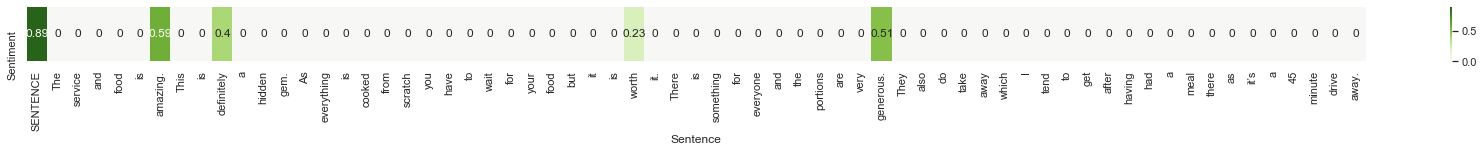

In [25]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Flair Sentiment analysis 

In [19]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

[POSITIVE (0.9613409042358398)]

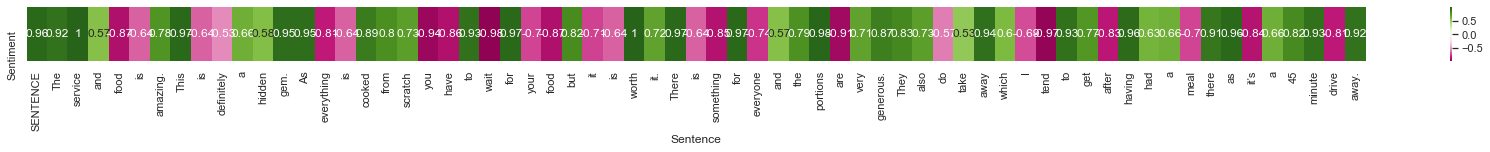

In [26]:
tokens = [token.text for token in s.tokens]
ss = [flair.data.Sentence(s) for s in tokens]
[flair_sentiment.predict(s) for s in ss]
sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]

visualise_sentiments({
      "Sentence":["SENTENCE"] + tokens,
      "Sentiment":[total_sentiment[0].score *(-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")]] + sentiments,
})

### Rating vs Sentiment score 

#### Vader

In [9]:
document['vader_score'] = document.content.map(lambda x: sid.polarity_scores(x)['compound'])

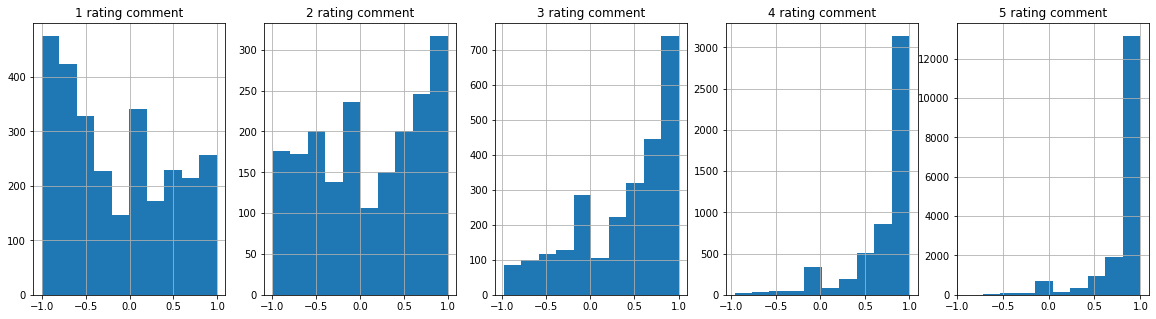

In [39]:
f = plt.figure(figsize=(20, 5))
for i in range(5):
    rating_doc = document[document['rating']==i+1]
    plt.subplot(1, 5, i+1)
    plt.title(f'{i+1} rating comment')
    rating_doc.vader_score.hist()
plt.show()